<a href="https://colab.research.google.com/github/tobiagru/StockPredictionAI-Tensorflow/blob/master/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## TPU

In [2]:
import os

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

TPU address is grpc://10.109.237.138:8470


In [0]:
import json
import tensorflow as tf

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  print(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

# Ideas

based on https://towardsdatascience.com/aifortrading-2edd6fac689d,:

# Import

In [0]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime, date
import pickle as pkl
from time import sleep
import os
import sys
import json
import random
import uuid
import ipywidgets as widgets

# BASE PATHS

In [0]:
DRIVE_BASE = '/content/drive/My Drive/Project/StockPredictionAI'

# Data / Features

In [0]:
data = pd.DataFrame()

## News

### Crawl

switch to "https://wireapi.reuters.com/v8/feed/rcom/us/marketnews/ric:MSFT.OQ?until={last wireitem_id}" 
- load new set of wireitems for last wireitem_id
- extract url, wireitem_id
- get articles for all urls and save them


In [0]:
!pip install scrapy

In [0]:
#Let's get us some MSFT news, we are going to get the data from reuters
import scrapy
import logging
import pickle as pkl
import time
import random
import json

import os
import psutil

class ReutersSpider(scrapy.Spider):
    name = 'blogspider'
    #start_urls = ['https://www.reuters.com/article/us-amazon-com-pentagon/u-s-judge-says-amazon-likely-to-succeed-on-key-argument-in-contract-challenge-idUSKBN20U0QC']
    #'https://www.reuters.com/search/news?blob=microsoft&sortBy=date&dateRange=all'
    
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'CONCURRENT_REQUESTS': 2,
        'COOKIES_ENABLED': False
    }
    
    def start_requests(self):
        #load indexed_pages.pkl or assign set
        urls = ["https://www.reuters.com/assets/searchArticleLoadMoreJson?blob=microsoft&bigOrSmall=big&articleWithBlog=true&sortBy=date&dateRange=all&numResultsToShow=500&pn={}&callback=addMoreNewsResults".format(idp) for idp in range(1,20)]
        
        for idx, url in enumerate(urls):
            yield scrapy.Request(url, self.parse_search)
    
    def parse_search(self, response):
        #the response is a js file #WhoDoesThat
        text = response.text
        start = text.find("news: [") + 6
        end = text.rfind("]") + 1
        content = text[start:end].replace('id:','"id":').\
                                  replace('headline:','"headline":').\
                                  replace('date:','"date":').\
                                  replace('href:','"href":').\
                                  replace('blurb:','"blurb":').\
                                  replace('mainPicUrl:','"mainPicUrl":')
        pages = json.loads(content)

        for page in pages:
            if os.path.exists("reuters/{}.json".format(page["date"])):
                print("Skipping ", page["date"], " already exists")
                continue
                    
            time.sleep(random.randrange(3,13))
            
            process = psutil.Process(os.getpid())
            print("{:.2f} mb - Working on {}".format(process.memory_info().rss / 1000000, page["date"]))
            yield scrapy.Request("https://www.reuters.com/{}".format(page["href"]),
                                 callback=self.parse,
                                 priority=99,
                                 cb_kwargs={"date":page["date"]})
                
    def parse(self, response, date):        
        content = [response.css('h1.ArticleHeader_headline::text').get()]
        content += response.css('div.StandardArticleBody_body').xpath('//p/text()').getall()
        
        print(date, " ... save")
        
        with open('reuters/{}.json'.format(date), 'w+') as file:
            file.write(json.dumps(content))
        
# we need an itemPipeline that get's rid of 

In [0]:
from scrapy.crawler import CrawlerProcess

process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(ReutersSpider)
process.start()


### Sentiment Analysis

Dimensions of Sentiment Analysis:  
Sensitivity = Text is [Postive (1), Neutral (0), Negative (-1)]  
Specificity = Text specific to MSFT: [High(1), Medium(0), Low(-1)]  
Objectiveness = Text is written [Objective(1), Mixed(0), Subjective(-1)]  
Intensity = Text is written [Emotionally (1), Mixed (0), Distant (-1)]  

---

Based on BERT paper: https://arxiv.org/abs/1810.04805  

using BERT model from tf.hub.  
* https://tfhub.dev/google/collections/bert/1
* https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb#scrollTo=y-wDZJCCTgtC 
* https://github.com/tensorflow/models/official/nlp/bert 

---

The stuff runs on TPU so we are using that to fine tune

---

Finetuning Dataset:
* ???
* Get random news (not for MSFT) from reuters for related companies. Take the stop movement the days after the news compared to before no change in trend = neutral, upward change = positive, downward = negative (This might lead to bias as we are trying to predict movement and the dataset tells the movement) - maybe AAPL, GOOGL, ...

In [4]:
!test -d models || git clone https://github.com/tensorflow/models.git models
if not 'models' in sys.path:
  sys.path += ['models']
!export PYTHONPATH="$PYTHONPATH:/content/models/official/nlp/bert"

Cloning into 'models'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 32900 (delta 0), reused 7 (delta 0), pack-reused 32893
Receiving objects: 100% (32900/32900), 511.90 MiB | 36.30 MiB/s, done.
Resolving deltas: 100% (21102/21102), done.
Checking out files: 100% (2437/2437), done.


In [6]:
import tensorflow_hub as hub
import tensorflow as tf
from tokenization import FullTokenizer

ModuleNotFoundError: ignored

### Import & Configs

In [0]:
BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'

BUCKET_BASE_DIR = 'gs://.../bert/'
#OUTPUT_DIR = BUCKET_BASE_DIR + 'models'

TEST_RATIO = 10 #%
EVAL_RATIO = 20 #%

NUM_OUTPUTS = 4

TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
MAX_SEQ_LENGTH = 128
WARMUP_PROPORTION = 0.1

#Checkpoints
CHECKPOINTS_DIR = BUCKET_BASE_DIR + 'checkpoints'
#check dir exists else create
CHECKPOINTS_NAME = os.path.join(CHECKPOINTS_DIR, 'bert_sensitivity.ckpt')
CHECKPOINTS_STEPS = 1000

#Summary
SUMMARY_DIR = BUCKET_BASE_DIR + 'summaries'
#check dir exists else create
SUMMARY_STEPS = 500

#Model Save
MODEL_SAVE_PATH = BUCKET_BASE_DIR + 'models'

### Prepare Dataset

Further Data:
* Financial Sentiment Lexicon: https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists
* Go for the Thomson Reuters News Archive and use multi language & multi source coverage together with a multi language BERT

In [0]:
# Convert Finetuning Set
# --> not "free" suitable found, have to label

In [0]:
# THIS ONLY RUNS IN NORMAL JUPYTER NOTEBOOK NOT IN COLAB

%gui asyncio
import asyncio

# WIP : Helper to label the reuters news

labeled_ratio = 10 #%

msft_keys = ['microsoft', 'msft', 'windows', 'office365', 'azure', 'xbox', 'surface']

known_segments = set()
paragraph_list = [['file','assignment']]

def wait_for_change(widget):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget.on_click(getvalue, remove=True)  
    widget.on_click(getvalue)
    return future

sensitivity = widgets.ToggleButtons(
    options=['Positive', 'Neutral', 'Negative'],
    value='Neutral',
    description='Sensitivity:',
    disabled=False,
    button_style='',
)

specificity = widgets.ToggleButtons(
    options=['High', 'Medium', 'Low'],
    value='Medium',
    description='Specificitiy:',
    disabled=False,
    button_style='',
)

objectiveness = widgets.ToggleButtons(
    options=['Objective', 'Mixed', 'Subjective'],
    value='Mixed',
    description='Objectiveness:',
    disabled=False,
    button_style='',
)

intensity = widgets.ToggleButtons(
    options=['Emotional', 'Mixed', 'Distant'],
    value='Mixed',
    description='Intensity:',
    disabled=False,
    button_style='',
)

text = widgets.Text(
    value='...',
    description='String:',
    disabled=True
)

button = widgets.Button(description='Next')

async def f():
    for path, subdir, articles in tf.io.gfile.walk('reuters'):
        for article in articles:
            with open(os.path.join(path, article)) as file:
                segments = json.loads(file.read())

            for segment in segments:
                segment_uuid = uuid.uuid1()
                segment = segment.lower()

                #dump segments that don't include any microsoft related key
            if not any([key in segment for key in msft_keys]):
                continue

            #dump segments that are duplicates
            #TODO depending on how many segments you have and what kind if VM you might be better of with a btree based on words or dumping it to file
            if segment in known_segments:
                continue
            else:
                known_segments.add(segment)

            #show random segments for labeling
            if random.randint(0,99) < labeled_ratio:
                text.value = segment
                segment_json = {'text': segment,
                                'sensitivity': sensitivity.value,
                                'specificity': specificity.value,
                                'objectiveness': objectiveness.value,
                                'intensity': intensity.value}

                await wait_for_change(button)
                print(segment_json)
                randint = random.randint(0,99)
                if randint < TEST_RATIO:
                    assigment = 'test'
                elif randint < TEST_RATIO + EVAL_RATIO:
                    assigment = 'eval'
                else:
                    assigment = 'train'
                print()
            else:
                segment_json = {'text': segment}
                assigment = 'unlabeled'

            fname = os.path.join(article.split(".")[0], "{}.txt".format(segment_uuid))
            paragraph_list.append((fname, assigment))
            print((fname, assigment))
            
            tf.io.gfile.makedirs(os.path.join(os.getcwd(), 'msft_segments', article.split(".")[0]))
            with open(os.path.join(os.getcwd(), 'msft_segments', fname), 'w+') as file:
                file.write(json.dumps(segment_json))

    with open(os.path.join(os.getcwd(), 'msft_segments', 'file_list.csv'), "w+") as file:
        for line in paragraph_list:
            file.write(",".join(line))
            file.write("\n")


asyncio.ensure_future(f())
display(text,
        sensitivity,
        specificity,
        objectiveness,
        intensity,
        button)

In [0]:
#from https://medium.com/@brn.pistone/bert-fine-tuning-for-tensorflow-2-0-with-keras-api-9913fc1348f6
def get_masks(tokens):
  """Mask for padding"""
  if len(tokens)>MAX_SEQ_LENGTH:
      raise IndexError("Token length more than max seq length!")
  return [1]*len(tokens) + [0] * (MAX_SEQ_LENGTH - len(tokens))


def get_segments(tokens):
  """Segments: 0 for the first sequence, 1 for the second"""
  if len(tokens)>MAX_SEQ_LENGTH:
      raise IndexError("Token length more than max seq length!")
  segments = []
  current_segment_id = 0
  for token in tokens:
      segments.append(current_segment_id)
      if token == "[SEP]":
          current_segment_id = 1
  return segments + [0] * (MAX_SEQ_LENGTH - len(tokens))


def get_ids(tokens, tokenizer):
  """Token ids from Tokenizer vocab"""
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_ids = token_ids + [0] * (MAX_SEQ_LENGTH-len(token_ids))
  return input_ids

### Model

In [0]:
#############
## Dataset Generator
#############

#batch_size=TRAIN_BATCH_SIZE,

def get_dataset_generator(dir, bert_layer, batch_size, train=True):
  def dataset():
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

    batch = []

    for path, subdir, paragraph_file in tf.io.gfile.walk(os.path.join(DRIVE_BASE,dir)):
      with open(os.path.join(path, subdir, paragraph_file)) as file:
        paragraph = json.loads(file.read())

      tokens = tokenizer.tokenize(paragraph)
      token_ids = get_ids(tokens, tokenizer)
      mask = get_masks(tokens)
      segment_ids = get_segments(tokens)
      
      batch.append((token_ids, mask, segment_ids), )

      if len(batch) == batch_size:
        yield batch
        batch = []
  
  return dataset

In [0]:
###########
## Model
###########

def create_model(bert_layer):
  """
  takes the bert_layer and creates a finetuning ready NN from it
  by adding classification (Fully + Softmax) at the end
  """
  # Inputs
  input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32,name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32,name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32,name="segment_ids")
  
  # Embedding (BERT)
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  
  # Classification
  x = tf.keras.layers.Flatten()(pooled_output) #we only need the [CLS] token
  x = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(x)
  output = tf.keras.layers.Dense(NUM_OUTPUTS, activation=tf.keras.activations.linear)(x)
  
  # Model
  model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=output)

  # TPU Strategy
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)

  # Compile
  with strategy.scope():
    model = create_model(bert_layer)
    model.compile(
        optimizer='adam', #tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), <-- this fails
        loss=tf.keras.losses.mean_squared_error,
        metrics=['accuracy'])
    
  return model

In [26]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)

InvalidArgumentError: ignored

In [25]:
#################
## Finetuning
#################

# Callbacks
checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINTS_NAME,
                                                 save_weights_only=True)
summary_callback = tf.keras.callbacks.TensorBoard(SUMMARY_DIR)
# Build Model

model = create_model(bert_layer)

# Train & Evaluate
model.fit(
    x=get_dataset_generator(dir, bert_layer),
    epochs=NUM_TRAIN_EPOCHS,
    validation_data=(testing_set, testing_label),
    verbose=1,
    callbacks=[checkpoint_callback, summary_callback],
    use_multiprocessing=True
)

#model save
model.save_weights(MODEL_SAVE_PATH)

InvalidArgumentError: ignored

In [0]:
# Predict Sentiment for all sentences and aggregate (sum) for article
if not model:
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)
  model = create_model(bert_layer)
  model.load_weights(MODEL_SAVE_PATH)

batch = []
tmp_result = np.zeros((PREDICT_BATCH_SIZE,5))
results = pd.DataFrame

for path, subdir, paragraph_file in tf.io.gfile.walk(os.path.join(DRIVE_BASE,dir)):
  with open(os.path.join(path, subdir, paragraph_file)) as file:
    paragraph = json.loads(file.read())

  tokens = tokenizer.tokenize(paragraph)
  token_ids = get_ids(tokens, tokenizer)
  mask = get_masks(tokens)
  segment_ids = get_segments(tokens)

  tmp_result[len(batch),0] = subdir
  batch.append((token_ids, mask, segment_ids))
  
  if len(batch) == PREDICT_BATCH_SIZE:
    tmp_result[:,1:] = model.predict(batch)
    cols = ["timestamp","News_Sensitivity","News_Specificity","News_Objectiveness","News_Intensity"]
    result[cols] = tmp_result
    batch = []
    tmp_result = np.zeros((PREDICT_BATCH_SIZE,5))

results['timestamp'] = pd.to_datetime(results['timestamp'], format="%B %d,%Y %I-%M%p %Z")
results = results.resample('D', on='timestamp').average().set_index('timestamp')
data = data.merge(results, how='outer', left_index=True, right_index=True)

## Stocks

In [6]:
!pip install alpha_vantage

  Created wheel for alpha-vantage: filename=alpha_vantage-2.1.3-cp36-none-any.whl size=14870 sha256=65cf37f7137083679ac48baa59f6ada2e3989097a14fce7534e183d4a4192575
  Stored in directory: /root/.cache/pip/wheels/d4/75/c2/483b0a988fd965b1128c1396a0ffadfb8903bd2bb569220048
Successfully built alpha-vantage


In [0]:
#import os
#key = 'your key'
#with open(os.path.join(DRIVE_BASE,'alpha_vantage_key.txt'), 'w+') as file:
#  file.write(key)

**Stocks to use:**
Major Business MSFT:
- Windows & Office
- Cloud
- Professional Software (ERP, Server, DB)
- Gaming
Impacts on MSFT:
- Global Trade (FX, {Import/Export})
- Healthyness of Companies (Stock Index, {GDP}, ...)
- {Consumer Buying Power - (CPI)}
  


In [0]:
msft_symbol = 'MSFT'

correlated_assets_symbols = [
    'AAPL',
    'GOOGL',
    'AMZN',
    'CRM', # Salesforce
    'SAP',
    '6758.TOK', # Sony
    'BABA', #Alibaba
    'IBM',
    'DELL',
    'HPQ', #HP
    'ORCL', # Oracle
    #'IXIC', #NasDaq -- doesn't work
    'DJI', # Dow Jones
    #'^NI225', # Nikkei
    'SPX', # S&P 500
    #'UKX', # FTSE
    'DAX',
    'HSI', # Heng Seng
    'ACN', # Accenture
    'INFY', # Infosys
    'DXC',
    'CTSH', # Cognizant
    'HCLTECH.NSE', #HCL
    'TCS', # Tata Consulting Services
    'WIPRO.NSE',
    'ATVI', #Activision
    'TCEHY', #Tencent
    'TTWO', # Take-Two Interactive
    'EA',
    'HUYA',
]

fx_symbols = [
    ('USD','JPY'),
    ('USD','GBP'),
    ('USD','EUR'),
    ('USD','CNY'),
]

In [0]:
import os
import requests

def alpha_vantage_request(function,
                          apikey_file=os.path.join(DRIVE_BASE,'alpha_vantage_key.txt'),
                          **kwargs):
  """
  expected kwargs:
   * TIME_SERIES_DAILY: symbol=<symbol>, outputsize='full'
   * FX_DAILY: from_symbol=<currency>, to_symbol=<currency>, outputsize='full'
  """
  
  with open(apikey_file, 'r') as file:
    apikey = file.read()
  
  url = "https://www.alphavantage.co/query"

  params = {'function':function,
            'apikey':apikey}

  params.update(kwargs)

  r = requests.get(url=url, params=params)

  if r.status_code == 200:
    return r.json() 
  else:
    raise KeyError("{} - {}".format(r.status_code, r.text))

In [75]:
if os.path.exists(os.path.join(DRIVE_BASE, 'msft.pkl')):
  print('MSFT ... loading from file')
  with open(os.path.join(DRIVE_BASE, 'msft.pkl'), 'rb') as file:
    msft = pkl.load(file)
else:
  print('MSFT ... loading from API')
  msft = alpha_vantage_request('TIME_SERIES_DAILY',
                             symbol=msft_symbol,
                             outputsize='full')
  with open(os.path.join(DRIVE_BASE, 'msft.pkl'), 'wb+') as file:
    pkl.dump(msft, file)
  
msft_df = pd.DataFrame(msft['Time Series (Daily)'], dtype=float).T
msft_df.index = pd.to_datetime(msft_df.index)
msft_df = msft_df.drop(['1. open', '2. high', '3. low', '5. volume'], axis=1)
msft_df = msft_df.rename(columns={'4. close':'MSFT'})
data = data.merge(msft_df, how='outer', left_index=True, right_index=True)

MSFT ... loading from file


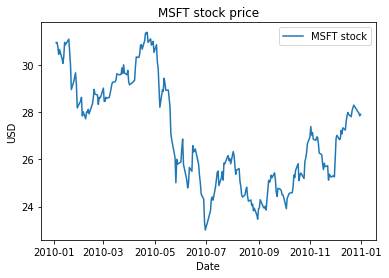

In [76]:
plt.plot(data.loc['2010', 'MSFT'], label='MSFT stock')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('MSFT stock price')
plt.legend()
plt.show()

In [77]:
save = False
if os.path.exists(os.path.join(DRIVE_BASE, 'correlated_assets.pkl')):
  print('Correlated Assets ... loading from file')
  with open(os.path.join(DRIVE_BASE, 'correlated_assets.pkl'), 'rb') as file:
    correlated_assets = pkl.load(file)
else:
  correlated_assets = {}
  save = True

N_idx = len(correlated_assets_symbols)
for idx, symbol in enumerate(correlated_assets_symbols):
  if not symbol in correlated_assets:
    print("{}/{}".format(idx,N_idx), symbol, ' ... loading')
    correlated_assets[symbol] = alpha_vantage_request('TIME_SERIES_DAILY',
                                                      symbol=symbol,
                                                      outputsize='full')
    save = True
    sleep(15)
  else:
    print("{}/{}".format(idx,N_idx), symbol, ' ... skipping, already exists')

if save:
  with open(os.path.join(DRIVE_BASE, 'correlated_assets.pkl'), 'wb+') as file:
    pkl.dump(correlated_assets, file)

idx = 0
for symbol, asset in correlated_assets.items():
  idx += 1
  print("{}/{}".format(idx,N_idx), symbol, ' ... merging')
  tmp_df = pd.DataFrame(asset['Time Series (Daily)'], dtype=float).T
  tmp_df.index = pd.to_datetime(tmp_df.index)
  tmp_df = tmp_df.drop(['1. open', '2. high', '3. low', '5. volume'], axis=1)
  tmp_df = tmp_df.rename(columns={'4. close':symbol})
  data = data.merge(tmp_df, how='outer', left_index=True, right_index=True)

Correlated Assets ... loading from file
0/27 AAPL  ... skipping, already exists
1/27 GOOGL  ... skipping, already exists
2/27 AMZN  ... skipping, already exists
3/27 CRM  ... skipping, already exists
4/27 SAP  ... skipping, already exists
5/27 6758.TOK  ... skipping, already exists
6/27 BABA  ... skipping, already exists
7/27 IBM  ... skipping, already exists
8/27 DELL  ... skipping, already exists
9/27 HPQ  ... skipping, already exists
10/27 ORCL  ... skipping, already exists
11/27 DJI  ... skipping, already exists
12/27 SPX  ... skipping, already exists
13/27 DAX  ... skipping, already exists
14/27 HSI  ... skipping, already exists
15/27 ACN  ... skipping, already exists
16/27 INFY  ... skipping, already exists
17/27 DXC  ... skipping, already exists
18/27 CTSH  ... skipping, already exists
19/27 HCLTECH.NSE  ... skipping, already exists
20/27 TCS  ... skipping, already exists
21/27 WIPRO.NSE  ... skipping, already exists
22/27 ATVI  ... skipping, already exists
23/27 TCEHY  ... skip

In [78]:
save = False
if os.path.exists(os.path.join(DRIVE_BASE, 'fx_rates.pkl')):
  print('FX Rates ... loading from file')
  with open(os.path.join(DRIVE_BASE, 'fx_rates.pkl'), 'rb') as file:
    fx_rates = pkl.load(file)
else:
  fx_rates = {}
  save = True

N_idx = len(fx_symbols)
for idx, fx in enumerate(fx_symbols):
  if not fx[0] + fx[1] in fx_rates:
    print("{}/{}".format(idx,N_idx), fx[0] + fx[1], ' ... loading')
    fx_rates[fx[0] + fx[1]] = alpha_vantage_request('FX_DAILY',
                                                    from_symbol=fx[0],
                                                    to_symbol=fx[1],
                                                    outputsize='full')
    sleep(15)
  else:
    print("{}/{}".format(idx,N_idx), fx[0] + fx[1], ' ... skipping, already exists')

if save:
  with open(os.path.join(DRIVE_BASE, 'fx_rates.pkl'), 'wb+') as file:
    pkl.dump(fx_rates, file)

idx = 0
for symbol, fx in fx_rates.items():
  idx += 1
  print("{}/{}".format(idx,N_idx), symbol, ' ... merging')
  tmp_df = pd.DataFrame(fx['Time Series FX (Daily)'], dtype=float).T
  tmp_df.index = pd.to_datetime(tmp_df.index)
  tmp_df = tmp_df.drop(['1. open', '2. high', '3. low'], axis=1)
  tmp_df = tmp_df.rename(columns={'4. close':symbol})
  data = data.merge(tmp_df, how='outer', left_index=True, right_index=True)

FX Rates ... loading from file
0/4 USDJPY  ... skipping, already exists
1/4 USDGBP  ... skipping, already exists
2/4 USDEUR  ... skipping, already exists
3/4 USDCNY  ... skipping, already exists
1/4 USDJPY  ... merging
2/4 USDGBP  ... merging
3/4 USDEUR  ... merging
4/4 USDCNY  ... merging


### Technical Indicators

In [79]:
#Only for MSFT
symbol='MSFT'

save = False
if os.path.exists(os.path.join(DRIVE_BASE, 'indicators.pkl')):
  print('FX Rates ... loading from file')
  with open(os.path.join(DRIVE_BASE, 'indicators.pkl'), 'rb') as file:
    indicators = pkl.load(file)
else:
  indicators = {}
  save = True

indicator_kwargs = {
    'SMA7': {'function':'SMA', 'symbol':symbol, 'interval':'daily', 'time_period':'7', 'series_type':'close'},
    'SMA21': {'function':'SMA', 'symbol':symbol, 'interval':'daily', 'time_period':'21', 'series_type':'close'},
    'EMA14': {'function':'EMA', 'symbol':symbol, 'interval':'daily', 'time_period':'14', 'series_type':'close'},
    'EMA29': {'function':'EMA', 'symbol':symbol, 'interval':'daily', 'time_period':'29', 'series_type':'close'},
    'BBANDS': {'function':'BBANDS', 'symbol':symbol, 'interval':'daily', 'time_period':'20', 'series_type':'close'},
    'MACD': {'function':'MACD', 'symbol':symbol, 'interval':'daily', 'series_type':'close'},
    'RSI': {'function':'RSI', 'symbol':symbol, 'interval':'daily', 'time_period':'14', 'series_type':'close'},
    'ADX': {'function':'ADX', 'symbol':symbol, 'interval':'daily', 'time_period':'14'}
}

for key, kwarg in indicator_kwargs.items():
  if not key in indicators:
    print(key, ' ... loading')
    indicators[key] = alpha_vantage_request(**kwarg)
    save = True
    sleep(15)
  else:
    print(key, ' ... skipping, already exists')

if save:
  with open(os.path.join(DRIVE_BASE, 'indicators.pkl'), 'wb+') as file:
    pkl.dump(indicators, file)

N_idx = len(indicators)
idx = 0
for symbol, fx in indicators.items():
  idx += 1
  print("{}/{}".format(idx,N_idx), symbol, ' ... merging')
  tmp_df = pd.DataFrame(fx[list(fx.keys())[1]], dtype=float).T
  tmp_df.index = pd.to_datetime(tmp_df.index)
  tmp_df = tmp_df.rename(columns={col:'{}_{}'.format(symbol,col) for col in tmp_df.keys()})
  data = data.merge(tmp_df, how='outer', left_index=True, right_index=True)

FX Rates ... loading from file
SMA7  ... skipping, already exists
SMA21  ... skipping, already exists
EMA14  ... skipping, already exists
EMA29  ... skipping, already exists
BBANDS  ... skipping, already exists
MACD  ... skipping, already exists
RSI  ... skipping, already exists
ADX  ... skipping, already exists
1/8 SMA7  ... merging
2/8 SMA21  ... merging
3/8 EMA14  ... merging
4/8 EMA29  ... merging
5/8 BBANDS  ... merging
6/8 MACD  ... merging
7/8 RSI  ... merging
8/8 ADX  ... merging


### Fourier Transform
Used to denoise the stock movement

**THE MSFT STOCK DOESNT OSCILLATE ENOUGH FOR FFT TO WORK***   
**--> NOT INCLUDED IN FEATUERS**

In [0]:
num_components = [3,12,48,188] #

In [119]:
fft = np.fft.fft(data.loc['2010':'2019', 'MSFT'].dropna().to_numpy())
a = np.fft.ifft(fft).astype(float)
bs = {}
for num_c in num_components:
  tmp_fft = np.zeros(fft.shape, dtype=np.csingle)
  tmp_fft[:num_c] = fft[:num_c]
  bs['FFT-{}'.format(num_c)] = (np.fft.ifft(tmp_fft).astype(float))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


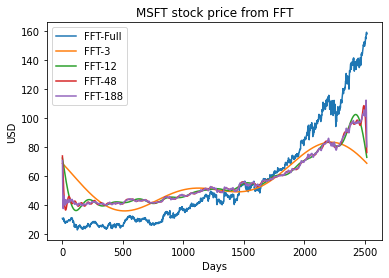

In [120]:
plt.plot(a, label='FFT-Full')
for key, b in bs.items():
  plt.plot(b, label=key)
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('MSFT stock price from FFT')
plt.legend()
plt.show()

### Arima
Not used to predict but to denoise the stock movement

### High Level Features
UNET to extract  
ULMNet to reduce dimensionality  
--> nore sure this makes sense but let's see

## Train/Test Split
Split by date and make something like the last two year as test

In [0]:
# Only include 2010 2019 - the 2020 chrisis might be a hard one


In [0]:
# Dump the test and train dataset and upload to GCS bucket


# Training
- let's start with just a LSTM, transformer and a CNN for prediciting the timeseries. We can always add the GAN later on
- Maybe turn it into a multitask learning exercise where it has to predict multiple stocks at the same time.
- Maybe use a transformer just on the stocks to predict trend, momentum, ... to see if the transformer is able to create new technical indicators

## Feature Evaluation & Selection

# Test